# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

<img src="images/sample_landmark_output.png" width="400">

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

In [1]:
# install the packages
# !pip install torchsummary
# !pip install split-folders
# # !pip install https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip
# !pip install efficientnet_pytorch

  Running setup.py bdist_wheel for efficientnet-pytorch ... done
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [4]:
# import all the packages
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torchsummary import summary

import torch 
from torch import nn
from torch import optim 
from torch.nn import functional as F

import helper

sns.set()
%matplotlib inline

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [2]:
# instantiate the transformations
batch_size= 20
train_path = '/data/landmark_images/train'
test_path = '/data/landmark_images/test'

# create loaders
train_loader, validation_loader, test_loader, dataset = helper.create_loaders(batch_size, train_path, test_path, own=True)
loaders_scratch = {'train': train_loader, 'valid': validation_loader, 'test': test_loader}

						Classes & Indexes
0:	Haleakala National Park
1:	Mount Rainier National Park
2:	Ljubljana Castle


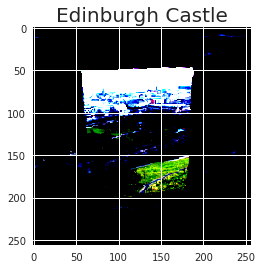

In [3]:
# show the first k image locations 
dictionary = helper.Dictionary(dataset)
dictionary.simple_print(3)

# visualize a single image from train set 
helper.visualize(train_loader, dictionary, single=True)

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**:<br> 
<b>Image Shape</b><br>
After looking into the dimensions of the images from different folder classes, I saw that the majority of the images have the shape of 600x600 (with small deviations +-150 on both axis). Therefore, <b>at first</b> I thought that the optimal shape would be 600x600. <br>
After experimenting with the different dimensions and going through research papers, I found that the standard is to resize to 226 and crop the center by 224. Not surprisingly, my model started training much faster. 
    
<b>Things that took me by surprise</b><br>
I was working on my local environment at first, and the transformations had the following steps: Normalize(...), ToTensor(), Resize(...). At that time everything worked perfectly. However, when I switched to Udacity's workspace, I kept getting errors because of the order of my transformations! It turned out that I <b>cannot</b> have normalization before ToTensor conversion. 

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

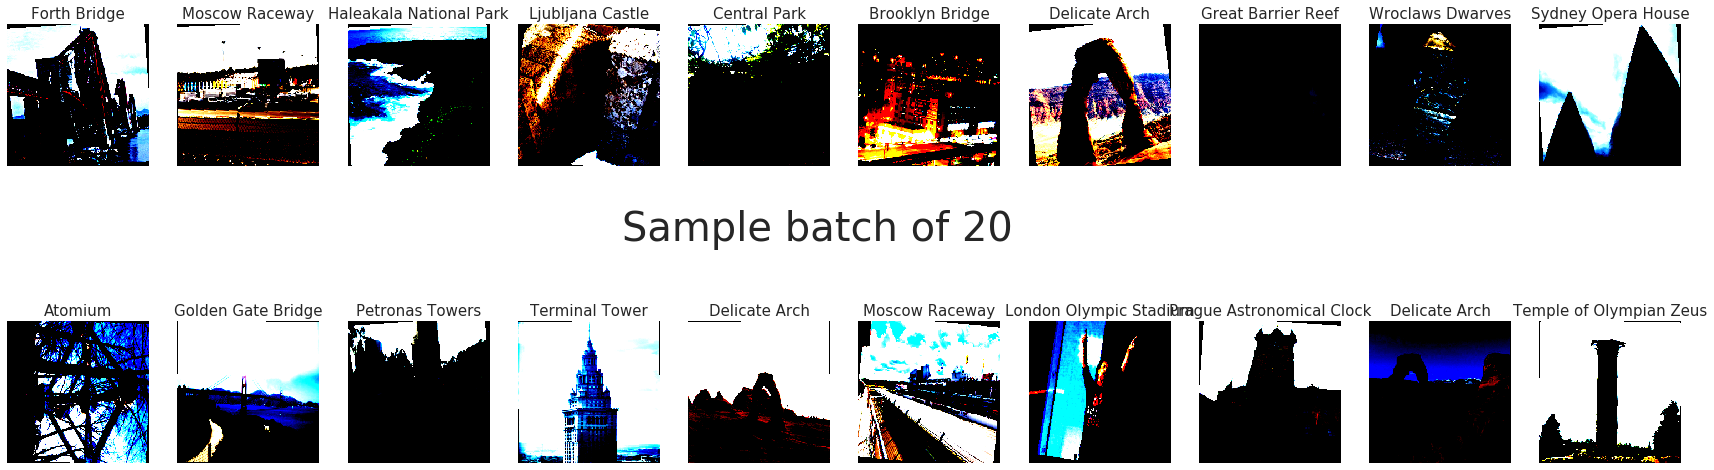

In [4]:
# visualize a batch of the train data loader
helper.visualize(train_loader, dictionary)

### Initialize use_cuda variable

In [5]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [6]:
## select loss function
criterion = nn.CrossEntropyLoss()

# instantiate optimizer
def get_optimizer(model):
    """
    This function creates the optimizer and its learning rate decay scheduler.

    Parameters:
        model: Model to use
    """
    # instantiate the optimizer
    optimizer = optim.Adagrad(model.parameters(), lr=0.01)

    # instantiate the learning decay scheduler
    lr_decay = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.96)
    return optimizer, lr_decay


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [8]:
n_outputs = 50

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # first convolutional layer (256x256x3 => 128x128x8)
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # second convolutional layer (128x128x8 => 64x64x16)
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # third convolutional layer (64x64x16 => 32x32x32)
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # fourth convolutional layer (32x32x32 => 16x16x64)
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # fifth convolutional layer (16x16x64 => 8x8x128)
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # define fully connected layers
        self.fc1 = nn.Linear(8*8*128, 1024)
        self.fc2 = nn.Linear(1024, 512)
        # define final output layer
        self.fc3 = nn.Linear(512, n_outputs)
        
        # define a dropout with 40% probability
        self.dropout = nn.Dropout(0.4)
    
    def forward(self, x):
        x = self.layer1(x)   # shape: 256 -> 128x128x8
        x = self.layer2(x)   # shape: 128 -> 64x64x16
        x = self.layer3(x)   # shape: 64  -> 32x32x32
        x = self.layer4(x)   # shape: 32  -> 16x16x64 
        x = self.layer5(x)   # shape: 16  -> 8x8x128
        
        # flatten for FC layers
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        # return the last layer without activation function
        return self.fc3(x)
        

In [9]:
#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()


In [10]:
# sanity check for the cnn architecture
summary(model_scratch, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]             224
              ReLU-2          [-1, 8, 256, 256]               0
         MaxPool2d-3          [-1, 8, 128, 128]               0
            Conv2d-4         [-1, 16, 128, 128]           1,168
              ReLU-5         [-1, 16, 128, 128]               0
         MaxPool2d-6           [-1, 16, 64, 64]               0
            Conv2d-7           [-1, 32, 64, 64]           4,640
              ReLU-8           [-1, 32, 64, 64]               0
         MaxPool2d-9           [-1, 32, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          18,496
             ReLU-11           [-1, 64, 32, 32]               0
        MaxPool2d-12           [-1, 64, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]          73,856
             ReLU-14          [-1, 128,

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ First, I've tried building with two layers. However, after experimenting, I saw that adding more convolutional layers was better. Thus, it turned out to have the best outputs with 5 convolutional layers. 

What's going on? There are five convolutional layers that are followed by three fully connected layer. The last, third FC layer, is the only one that doesn't have the activation function on it since we're dealing with classifications. I've also instantiated a dropout with 40% because it gives the best solution for over- and underfitting. 


### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [11]:
def train(n_epochs:int, loaders:dict, model, optimizer, criterion, use_cuda:bool,
          save_path:str, learning_decay_scheduler):
    """
    This function trains the model and shows the progress.

    Parameters:
        n_epochs (int): Number of epochs to train for
        loaders (dict): Dictionary of loaders to use
        model: Model being used
        optimizer: Selected optimizer
        criterion: Loss function
        use_cuda (bool): If GPU is enables or not
        save_path (str): Path to store the results in
        learning_decay_scheduler: Learning rate decay scheduler to use

    Returns:
        A trained model
    """
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            # record the average training loss, using something like
            optimizer.zero_grad()
            
            # get the final outputs
            output = model(data)
            
            # calculate the loss
            loss = criterion(output, target)
            
            # start back propagation
            loss.backward()
            
            # update the weights
            optimizer.step()
            
            train_loss += loss.item() * data.size(0)

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
        
        train_loss /= len(train_loader.sampler)
        valid_loss /= len(validation_loader.sampler)
        
        # print training/validation statistics every 5 epochs
        if epoch % 5 == 0:
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, 
                train_loss,
                valid_loss
                ))

        ## if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

        # update learning rate decay
        learning_decay_scheduler.step()
            
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [12]:
def custom_weight_init(m):
    """
    This function create custom uniform weights.

    Parameters:
        m: Model being used
    """
    # implement a weight initialization strategy
    classname = m.__class__.__name__
    # set the weights to uniform distribution
    if classname.find('Linear') != -1:
        n = m.in_features
        y = 1.0 / np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        # fill the bias as well
        m.bias.data.fill_(0)

#-#-# Do NOT modify the code below this line. #-#-#
model_scratch.apply(custom_weight_init)
optim, lr_decay = get_optimizer(model_scratch)
model_scratch = train(2, loaders_scratch, model_scratch, optim,
                      criterion, use_cuda, 'ignore.pt', lr_decay)

Validation loss decreased (inf --> 3.846556).  Saving model ...
Validation loss decreased (3.846556 --> 3.764588).  Saving model ...


### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [13]:
# set the number of epochs
num_epochs = 30

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    """
    This function sets custom weights to see check the difference in weights re-declaration.

    Parameters:
        m: Model being used
    """
    # manually reset the weights
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, optim, 
                      criterion, use_cuda, 'model_scratch.pt', lr_decay)

Validation loss decreased (inf --> 3.858780).  Saving model ...
Validation loss decreased (3.858780 --> 3.733438).  Saving model ...
Validation loss decreased (3.733438 --> 3.568388).  Saving model ...
Validation loss decreased (3.568388 --> 3.451649).  Saving model ...
Epoch: 5 	Training Loss: 3.354908 	Validation Loss: 3.366057
Validation loss decreased (3.451649 --> 3.366057).  Saving model ...
Validation loss decreased (3.366057 --> 3.217735).  Saving model ...
Validation loss decreased (3.217735 --> 3.131359).  Saving model ...
Validation loss decreased (3.131359 --> 3.043584).  Saving model ...
Validation loss decreased (3.043584 --> 3.022706).  Saving model ...
Epoch: 10 	Training Loss: 2.818525 	Validation Loss: 2.942425
Validation loss decreased (3.022706 --> 2.942425).  Saving model ...
Validation loss decreased (2.942425 --> 2.897223).  Saving model ...
Validation loss decreased (2.897223 --> 2.863922).  Saving model ...
Validation loss decreased (2.863922 --> 2.803423).  Sa

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [14]:
def test(loaders, model, criterion, use_cuda):
    """
    This functions calculates the correctness and shows the results of the architecture.

    Parameters:
        loaders: Dictionary that stores all three loaders
        model: Model used for implementation
        criterion: Loss function
        use_cuda: If GPU is available or not

    Returns:
        The accuracy of the model
    """
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    # show the accuracy
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [16]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion, use_cuda)

Test Loss: 2.350165


Test Accuracy: 41% (520/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [7]:
# re-intstantiate the dictionary holder for loaders
train_loader, validation_loader, test_loader, dataset = helper.create_loaders(batch_size, train_path, test_path, own=False)
loaders_transfer = {'train': train_loader, 'valid': validation_loader, 'test': test_loader}


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [8]:
import torchvision.models as models
model_transfer = models.vgg16(pretrained=True)
print(model_transfer)

#-#-# Do NOT modify the code below this line. #-#-#
if use_cuda:
    model_transfer = model_transfer.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  Since we were introduced to VGG16 model before, I wanted to see how well it would work. Even though this classifier was built for ImageNet with 1000 different classes, we see that this model is suitable. And it correctly classifies roughly 75% of the data, which is incredible in comparison to the one I've built in the previous step. The steps were to change the last parameters in the classifier. Specifically, the last out_feature to classify 50 landmarks. 

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [9]:
# freeze parameters 
for param in model_transfer.features.parameters():
    param.requires_grad = False

model_transfer.classifier[6] = nn.Linear(model_transfer.classifier[6].in_features, 50)
print(model_transfer.classifier)

if use_cuda:
    model_transfer.cuda()


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=50, bias=True)
)


In [20]:
# sanity check for the correctness of the algorithm
summary(model_transfer, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [11]:
from torch import optim 


def get_optimizer_transfer(model):
    """
    This function creates the optimizer and its learning rate decay scheduler.

    Parameters:
        model: Model to use
    """
    # instantiate the optimizer
    optimizer = optim.Adagrad(model.classifier.parameters(), lr=1e-2)
    # instantiate the learning decay scheduler
    lr_decay = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.96)
    return optimizer, lr_decay

# get the optimizer and LR decay scheduler
optimizer, lr_decay = get_optimizer_transfer(model_transfer)

In [33]:
model_transfer = train(25, loaders_transfer, model_transfer, optimizer, 
                       criterion, use_cuda, 'model_transfer.pt', lr_decay)

Validation loss decreased (inf --> 2.081740).  Saving model ...
Validation loss decreased (2.081740 --> 1.711221).  Saving model ...
Validation loss decreased (1.711221 --> 1.548266).  Saving model ...
Validation loss decreased (1.548266 --> 1.540083).  Saving model ...
Epoch: 5 	Training Loss: 1.124998 	Validation Loss: 1.412112
Validation loss decreased (1.540083 --> 1.412112).  Saving model ...
Validation loss decreased (1.412112 --> 1.384080).  Saving model ...
Validation loss decreased (1.384080 --> 1.363306).  Saving model ...
Validation loss decreased (1.363306 --> 1.359355).  Saving model ...
Epoch: 10 	Training Loss: 0.470693 	Validation Loss: 1.319398
Validation loss decreased (1.359355 --> 1.319398).  Saving model ...
Epoch: 15 	Training Loss: 0.256641 	Validation Loss: 1.402644
Epoch: 20 	Training Loss: 0.165713 	Validation Loss: 1.367986
Epoch: 25 	Training Loss: 0.121157 	Validation Loss: 1.449945


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [15]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

# check the test results
test(loaders_transfer, model_transfer, criterion, use_cuda)

Test Loss: 1.197492


Test Accuracy: 71% (899/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [17]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path:str, k:int):
    """
    This function read the image file, applies appropriate transformations, predicts top K locations of images.

    Parameters:
         img_path (str): Path to an image
         k (int): Top locations to show

    Returns:
        transformed image and pretty formatted location predictions
    """
    # transform the image
    img = helper.create_loaders(0, img_path=img_path, single=True)

    # pass the model in evaluation mode
    model_transfer.eval()
    # get predictions
    output = model_transfer(img)
    # apply softmax to get probabilities
    output = F.softmax(output, dim=1)
    # show top K location predictions
    topk = torch.topk(output, k)

    return img, dictionary.get_content(topk[1].detach().cpu().numpy()[0])

# test on a sample image
_, output = predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)
output

'Golden Gate Bridge, Forth Bridge, Brooklyn Bridge, Sydney Harbour Bridge, Dead Sea'

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

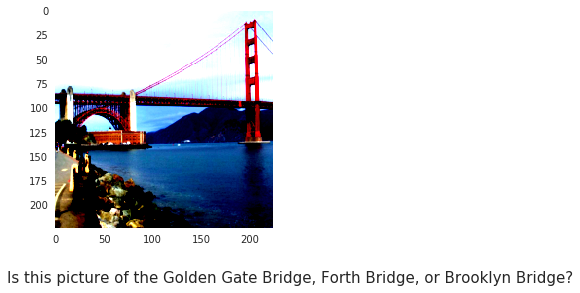

In [18]:
def suggest_locations(img_path: str):
    """
    This function shows the final image and associated K predictions.

    Parameters:
        img_path (str): Path to an image
    """
    # get landmark predictions
    img, predicted_landmarks = predict_landmarks(img_path, 3)

    # create pretty output depending on K [1, 5] locations
    text = 'Is this picture of the '
    # show prediction for one location
    if not predicted_landmarks.find(','):
        text = predicted_landmarks + '?'
    else:
        # show prediction for two locations
        landmarks = predicted_landmarks.split(', ')
        if len(landmarks) == 2:
            text += landmarks[0] + ' or ' + landmarks[1] + '?'
        else:
            # show prediction for more than two locations
            text += ', '.join(landmarks[:-1]) + ', or ' + landmarks[-1] + '?'
    # normalize the image and show the predictions
    convert = lambda x: np.clip(x.cpu().numpy().transpose((1, 2, 0)), 0, 1)
    image = convert(img[0, :])
    plt.imshow(image)
    plt.text(-50, 280, text, fontsize=15)
    plt.grid(None)
    plt.show()


# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
It was surprising to see that Golden Gate hasn't been classified properly, even though there's an equal distribution of images (100 images/folder), with the only exception being Temple_of_Olympian_Zeus which has 96 instances. Generally, the results are satisfactory, the algorithm was able to classify 75% of images. <br>
Deep learning gives that incredible possibility to get the most accurate results. Thus, there are some things that I need to take care of:
* Get more images
* Experiment with other transfer learning algorithms and find the best performing model
* Try autoencoders as dimensionality reduction in the preprocessing step and check against the results here
* Read more researches to find the state-of-the-art pipelines used today for landmark classification

All the aforementioned findings are going to be covered in the next notebook :)

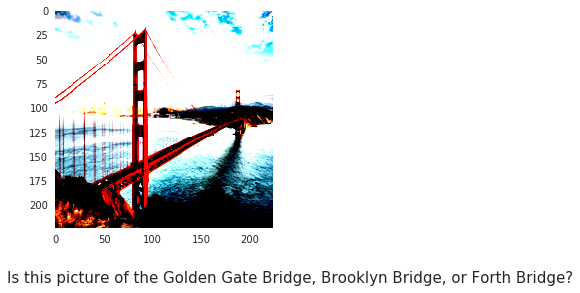

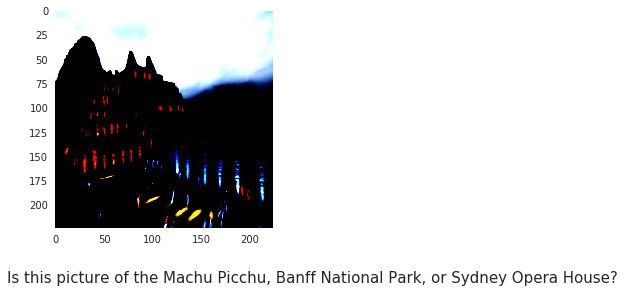

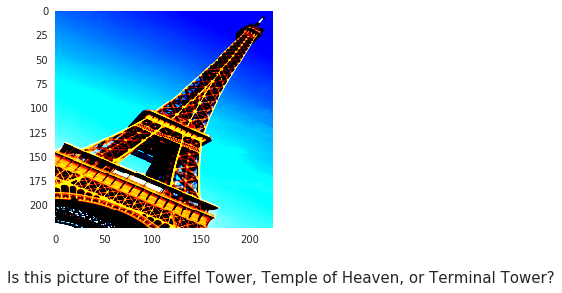

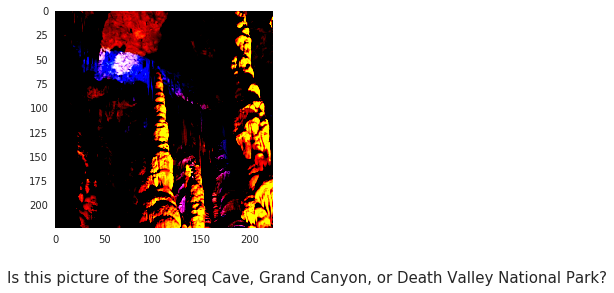

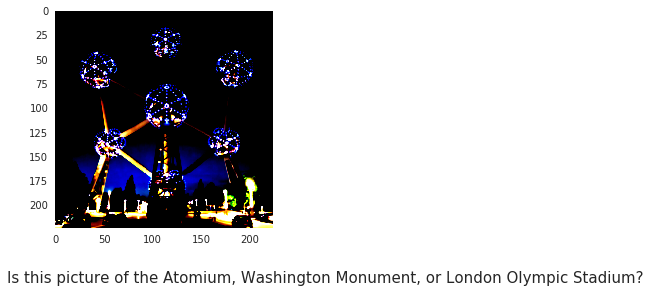

In [19]:
## Execute the `suggest_locations` function on
## at least 4 images on your computer.
suggest_locations('images/test/09.Golden_Gate_Bridge/gate.jpg')
suggest_locations('images/test/41.Machu_Picchu/m.jpg')
suggest_locations('images/test/16.Eiffel_Tower/tower.jpg')
suggest_locations('images/test/24.Soreq_Cave/1f.jpg')
suggest_locations('images/test/37.Atomium/at.jpg')

